<a href="https://colab.research.google.com/github/jiminseon/AI_RecommenderSystem/blob/main/Kobert%EB%AA%A8%EB%8D%B8(%EA%B0%80%EC%A4%91%EC%B9%98%2B%EB%A1%9C%EA%B7%B8_241027_%EB%AF%BC%EC%84%A0ver).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#1.Colab 환경설정

In [ ]:
#필요 패키지 설치
!pip install mxnet
!pip install gluonnlp==0.8.0
!pip install tqdm pandas
!pip install sentencepiece
!pip install transformers
!pip install torch
!pip install numpy==1.23.1

#KoBERT 깃허브에서 불러오기
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-sg4b5jeb/kobert-tokenizer_60ae82a74dd04c74806c16e9883f518d
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-sg4b5jeb/kobert-tokenizer_60ae82a74dd04c74806c16e9883f518d
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 5c46b1c68e4755b54879431bd302db621f4d2f47
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
import pandas as pd

#  Hugging Face를 통한 모델 및 토크나이저 Import
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

/usr/local/lib/python3.10/dist-packages/mxnet/optimizer/optimizer.py:163: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  warnings.warn('WARNING: New optimizer %s.%s is overriding '


In [ ]:
n_devices = torch.cuda.device_count()
print(n_devices)

for i in range(n_devices):
    print(torch.cuda.get_device_name(i))

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

1
Tesla T4
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# 2. 데이터 전처리

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/캡스톤6조/kobert/kobert.csv')
df

,Unnamed: 0,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템문장1,사람문장2,시스템문장2,사람문장3,시스템문장3
0,1.0,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,일은 왜 해도 해도 끝이 없을까? 화가 난다.,많이 힘드시겠어요. 주위에 의논할 상대가 있나요?,그냥 내가 해결하는 게 나아. 남들한테 부담 주고 싶지도 않고.,혼자 해결하기로 했군요. 혼자서 해결하기 힘들면 주위에 의논할 사람을 찾아보세요.,NaN,NaN
1,2.0,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.,급여가 줄어 속상하시겠어요. 월급이 줄어든 것을 어떻게 보완하실 건가요?,최대한 지출을 억제해야겠어. 월급이 줄어들었으니 고정지출을 줄일 수밖에 없을 것 같아.,월급이 줄어든 만큼 소비를 줄일 계획이군요.,NaN,NaN
2,3.0,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,회사 동료 때문에 스트레스를 많이 받는 것 같아요. 문제 해결을 위해 어떤 노력을 ...,잘 안 맞는 사람이랑 억지로 잘 지내는 것보단 조금은 거리를 두고 예의를 갖춰서 대...,스트레스받지 않기 위해선 인간관계에 있어 약간의 거리를 두는 게 좋겠군요.,NaN,NaN
3,4.0,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,관련 없는 심부름을 모두 하게 되어서 노여우시군요. 어떤 것이 상황을 나아질 수 있...,직장 사람들과 솔직하게 이야기해보고 싶어. 일하는 데에 방해된다고.,직장 사람들과 이야기를 해 보겠다고 결심하셨군요.,NaN,NaN
4,5.0,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.,무시하는 것 같은 태도에 화가 나셨군요. 상대방의 어떤 행동이 그런 감정을 유발하는...,상사인 나에게 먼저 인사하지 않아서 매일 내가 먼저 인사한다고!,항상 먼저 인사하게 되어 화가 나셨군요. 어떻게 하면 신입사원에게 화났음을 표현할 ...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53466,NaN,NaN,NaN,NaN,NaN,외로움,NaN,너무 보고 싶어서 어떻게 해야 할지 모르겠어.,NaN,NaN,NaN,NaN,NaN
53467,NaN,NaN,NaN,NaN,NaN,외로움,NaN,네가 남긴 기억들이 자꾸 떠올라서 마음이 아파.,NaN,NaN,NaN,NaN,NaN
53468,NaN,NaN,NaN,NaN,NaN,외로움,NaN,너무 그리워서 어떻게 해야 할지 모르겠어.,NaN,NaN,NaN,NaN,NaN
53469,NaN,NaN,NaN,NaN,NaN,외로움,NaN,그때로 돌아갈 수만 있다면 얼마나 좋을까.,NaN,NaN,NaN,NaN,NaN


In [ ]:
#슬픔&상처&불안 -> 우울로 변경
df.loc[df['감정_대분류'] == '슬픔', '감정_대분류'] = '우울'
df.loc[df['감정_대분류'] == '상처', '감정_대분류'] = '우울'
df.loc[df['감정_대분류'] == '불안', '감정_대분류'] = '우울'

In [ ]:
# 당황 데이터 제거
df = df[df['감정_대분류'] != '당황'].reset_index(drop=True)
df['감정_대분류'].value_counts()

,count
감정_대분류,
우울,27588
분노,9160
기쁨,6126
외로움,841
즐거움,500
사랑,500


In [ ]:
df = df.reset_index(drop=True)
df = df[['감정_대분류', '사람문장1']]
df

,감정_대분류,사람문장1
0,분노,일은 왜 해도 해도 끝이 없을까? 화가 난다.
1,분노,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.
2,분노,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...
3,분노,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...
4,분노,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.
...,...,...
44710,외로움,너무 보고 싶어서 어떻게 해야 할지 모르겠어.
44711,외로움,네가 남긴 기억들이 자꾸 떠올라서 마음이 아파.
44712,외로움,너무 그리워서 어떻게 해야 할지 모르겠어.
44713,외로움,그때로 돌아갈 수만 있다면 얼마나 좋을까.


In [ ]:
df['감정_대분류'].unique()

array(['분노', '기쁨', '우울', '즐거움', '사랑', '외로움'], dtype=object)

In [ ]:
# 6개의 감정 class → 숫자
df.loc[(df['감정_대분류'] == "기쁨"), '감정_대분류'] = 0  # 기쁨 → 0
df.loc[(df['감정_대분류'] == "즐거움"), '감정_대분류'] = 1  # 즐거움 → 1
df.loc[(df['감정_대분류'] == "사랑"), '감정_대분류'] = 2  # 사랑 → 2
df.loc[(df['감정_대분류'] == "분노"), '감정_대분류'] = 3  # 분노 → 3
df.loc[(df['감정_대분류'] == "우울"), '감정_대분류'] = 4  # 우울 → 4
df.loc[(df['감정_대분류'] == "외로움"), '감정_대분류'] = 5  # 외로움 → 5

In [ ]:
df['감정_대분류'].unique()

array([3, 0, 4, 1, 2, 5], dtype=object)

In [ ]:
data_list = []
for q, label in zip(df['사람문장1'], df['감정_대분류'])  : ## BERTDataset에 input으로 주기 위해 문장과 감정라벨로 이루어진 list append
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

In [ ]:
print(len(data_list))
print(data_list[0])
print(data_list[150])
print(data_list[1500])
print(data_list[3000])
print(data_list[-1])

44715
['일은 왜 해도 해도 끝이 없을까? 화가 난다.', '3']
['내가 친해지고 싶은 사람과 전화번호를 교환했어.', '0']
['부모님께 연예인이 꿈이라고 말씀드리면 안 된다고 하실까 봐 걱정이야.', '4']
['출산예정일이 지났는데 진통이 오지 않아서 마음이 조마조마해.', '4']
['너무 보고 싶어서 가슴이 아파.', '5']


#3.데이터 분리


In [ ]:
from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(data_list, test_size=0.25, random_state=0)

print(len(dataset_train))
print(len(dataset_test))

33536
11179


In [ ]:
from collections import Counter
from sklearn.utils.class_weight import compute_sample_weight
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
import pandas as pd
import torch

# dataset_train에서 레이블(두 번째 항목)을 추출하여 카운트
labels_train = [item[1] for item in dataset_train]
label_counts_train = Counter(labels_train)

# 레이블 분포 출력 --> train 데이터 내부에서 데이터 편향 문제 발생
print("Train 데이터 레이블 분포:")
print(label_counts_train)

Train 데이터 레이블 분포:
Counter({'4': 20707, '3': 6861, '0': 4615, '5': 638, '1': 365, '2': 350})


In [ ]:
import random

# 언더샘플링 대상 레이블 설정 및 목표 샘플 수 정의
target_counts = {'4': 6000, '3': 4000, '0': 4000}

# 언더샘플링 적용할 데이터셋
final_dataset_train = []

# 레이블별로 데이터를 그룹화
data_by_label = {label: [] for label in target_counts.keys()}

# 레이블별로 데이터를 분류
for sentence, label in dataset_train:
    if label in target_counts:
        data_by_label[label].append((sentence, label))

# 다수 클래스는 목표 샘플 수만큼 무작위 샘플링
for label, items in data_by_label.items():
    target_count = target_counts[label]
    sampled_items = random.sample(items, target_count) if len(items) > target_count else items
    final_dataset_train.extend(sampled_items)

# 소수 클래스는 그대로 추가
for sentence, label in dataset_train:
    if label not in target_counts:
        final_dataset_train.append((sentence, label))

print("Undersampled Train Dataset Size:", len(final_dataset_train))

Undersampled Train Dataset Size: 15353


In [ ]:
# dataset_train에서 레이블(두 번째 항목)을 추출하여 카운트
labels_train = [item[1] for item in final_dataset_train]
label_counts_train = Counter(labels_train)

# 레이블 분포 출력
print("Train 데이터 레이블 분포:")
print(label_counts_train)

Train 데이터 레이블 분포:
Counter({'4': 6000, '3': 4000, '0': 4000, '5': 638, '1': 365, '2': 350})


In [ ]:
labels_train_series = pd.Series(labels_train)
class_counts = labels_train_series.value_counts().to_dict()  # 딕셔너리 형태로 변경
num_samples = sum(class_counts.values())  # 총 샘플 수

# 클래스별 가중치 부여 (딕셔너리 형태로)
class_weights = {label: num_samples / count for label, count in class_counts.items()}

# 해당 데이터의 label에 해당되는 가중치 부여
weights = [class_weights[label] for label in labels_train]

# WeightedRandomSampler 정의
sampler = WeightedRandomSampler(weights=torch.DoubleTensor(weights), num_samples=len(weights))

class_weights

{'4': 2.5588333333333333,
 '3': 3.83825,
 '0': 3.83825,
 '5': 24.064263322884013,
 '1': 42.06301369863014,
 '2': 43.86571428571428}

# 4. 데이터 변환 (토큰화, 정수 인코딩, 패딩)


In [ ]:
## Setting parameters
max_len = 64
batch_size = 32
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate = 1e-5

In [ ]:
## BERT 스타일의 데이터 변환을 수행하는 클래스
## BERT 모델에 입력되는 문장 또는 문장 쌍을 적절한 형식으로 변환해 모델이 이해할 수 있도록 함


class BERTSentenceTransform:
    r"""BERT style data transformation.

    Parameters
    ----------
    tokenizer : BERTTokenizer.
        Tokenizer for the sentences.
    max_seq_length : int.
        Maximum sequence length of the sentences.
    pad : bool, default True
        Whether to pad the sentences to maximum length.
    pair : bool, default True
        Whether to transform sentences or sentence pairs.
    """

    # 입력으로 받은 tokenizerm 최대 시퀀스 길이, vocab, pad 및 pair 설정
    def __init__(self, tokenizer, max_seq_length,vocab, pad=True, pair=True):
        self._tokenizer = tokenizer
        self._max_seq_length = max_seq_length
        self._pad = pad
        self._pair = pair
        self._vocab = vocab

    # 입력된 문장 또는 문장 쌍을 BERT 모델이 사용할 수 있는 형식으로 변환
    def __call__(self, line):
        """Perform transformation for sequence pairs or single sequences.

        The transformation is processed in the following steps:
        - tokenize the input sequences
        - insert [CLS], [SEP] as necessary
        - generate type ids to indicate whether a token belongs to the first
        sequence or the second sequence.
        - generate valid length

        For sequence pairs, the input is a tuple of 2 strings:
        text_a, text_b.

        Inputs:
            text_a: 'is this jacksonville ?'
            text_b: 'no it is not'
        Tokenization:
            text_a: 'is this jack ##son ##ville ?'
            text_b: 'no it is not .'
        Processed:
            tokens: '[CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]'
            type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
            valid_length: 14

        For single sequences, the input is a tuple of single string:
        text_a.

        Inputs:
            text_a: 'the dog is hairy .'
        Tokenization:
            text_a: 'the dog is hairy .'
        Processed:
            text_a: '[CLS] the dog is hairy . [SEP]'
            type_ids: 0     0   0   0  0     0 0
            valid_length: 7

        Parameters
        ----------
        line: tuple of str
            Input strings. For sequence pairs, the input is a tuple of 2 strings:
            (text_a, text_b). For single sequences, the input is a tuple of single
            string: (text_a,).

        Returns
        -------
        np.array: input token ids in 'int32', shape (batch_size, seq_length)
        np.array: valid length in 'int32', shape (batch_size,)
        np.array: input token type ids in 'int32', shape (batch_size, seq_length)

        """

        # convert to unicode
        text_a = line[0]
        if self._pair:
            assert len(line) == 2
            text_b = line[1]

        tokens_a = self._tokenizer.tokenize(text_a)
        tokens_b = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            self._truncate_seq_pair(tokens_a, tokens_b,
                                    self._max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]

        # The embedding vectors for `type=0` and `type=1` were learned during
        # pre-training and are added to the wordpiece embedding vector
        # (and position vector). This is not *strictly* necessary since
        # the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.

        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        #vocab = self._tokenizer.vocab
        vocab = self._vocab
        tokens = []
        tokens.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)

        # The valid length of sentences. Only real  tokens are attended to.
        valid_length = len(input_ids)

        if self._pad:
            # Zero-pad up to the sequence length.
            padding_length = self._max_seq_length - valid_length
            # use padding tokens for the rest
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            segment_ids.extend([0] * padding_length)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'),\
            np.array(segment_ids, dtype='int32')

In [ ]:
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

## 주어진 데이터셋을 KoBERT 모델에 입력으로 사용할 수 있는 형식으로 변환 후 이를 토대로 텍스트 분류 작업을 수행할 수 있도록 함
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        #transform = nlp.data.BERTSentenceTransform(
        #    tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')


data_train = BERTDataset(final_dataset_train, 0, 1, tokenizer, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tokenizer, vocab, max_len, True, False)

# KoBERTTokenizer를 사용해 한국어 BERT용 토크나이저와 BertModle을 사용해 사전 학습된 KoBERT 모델 불러옴
# nlp.vocab 사용해 BERT 모델의 어휘 불러옴
# 학습 및 테스트 데이터셋을 BERTDataset 클래스를 사용해 준비 --> 각각의 문장은 토큰화되고 어휘에 따라 숫자로 인덱싱됨

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=2,sampler=sampler, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=2)

#5-1. Kobert softmax

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size=768,
                 num_classes=6,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
        self.softmax = nn.Softmax(dim=1)  # Softmax로 변경
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=hidden_size, out_features=512),
            nn.Linear(in_features=512, out_features=num_classes),
        )

        # 정규화 레이어 추가 (Layer Normalization)
        self.layer_norm = nn.LayerNorm(768)

        # 드롭아웃
        self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        _, pooler = self.bert(input_ids=token_ids, token_type_ids=segment_ids.long(), attention_mask=attention_mask.float().to(token_ids.device))

        pooled_output = self.dropout(pooler)
        normalized_output = self.layer_norm(pooled_output)
        out = self.classifier(normalized_output)

        # LayerNorm 적용
        pooler = self.layer_norm(pooler)

        if self.dr_rate:
            pooler = self.dropout(pooler)

        logits = self.classifier(pooler)  # 분류를 위한 로짓 값 계산
        probabilities = self.softmax(logits)  # Softmax로 각 클래스의 확률 계산
        return probabilities  # 각 클래스에 대한 확률 반환


In [ ]:
#정의한 모델 불러오기
model = BERTClassifier(bertmodel,dr_rate=0.4).to(device)
#model = BERTClassifier(bertmodel,  dr_rate=0.5).to('cpu')

# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
train_dataloader

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.metrics import f1_score

# 각 에포크의 F1 스코어를 저장할 리스트 초기화
train_f1_scores = []
test_f1_scores = []

# 모델 훈련 및 평가
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    total_loss = 0.0
    all_train_preds = []
    all_train_labels = []
    all_test_preds = []
    all_test_labels = []
    train_losses = []
    train_accuracies = []
    test_accuracies =[]
    avg_test_acc=0.0
    model.train()

    # 훈련 데이터 학습
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        total_loss += loss.item()
        train_acc += calc_accuracy(out, label)

        # 예측값과 실제 라벨 저장
        _, preds = torch.max(out, dim=1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(label.cpu().numpy())

    # 에포크별 평균 손실 및 정확도 계산
    avg_train_loss = total_loss / len(train_dataloader)
    avg_train_acc = train_acc / len(train_dataloader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # F1 스코어 계산
    train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')
    train_f1_scores.append(train_f1)

    print(f"epoch {e+1} train loss {avg_train_loss} train acc {avg_train_acc} train f1 {train_f1}")

    # 검증 데이터 평가
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)

        # 예측값과 실제 라벨 저장
        _, preds = torch.max(out, dim=1)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(label.cpu().numpy())

    # 에포크별 테스트 정확도 및 F1 스코어 계산
    avg_test_acc = test_acc / len(test_dataloader)
    test_accuracies.append(avg_test_acc)
    test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
    test_f1_scores.append(test_f1)

    print(f"epoch {e+1} test acc {avg_test_acc} test f1 {test_f1}")


<ipython-input-24-5be844c99c5b>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/480 [00:00<?, ?it/s]

epoch 1 train loss 1.4686812209586302 train acc 0.5835390625 train f1 0.5749918812399155


<ipython-input-24-5be844c99c5b>:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/350 [00:00<?, ?it/s]

epoch 1 test acc 0.7328084415584416 test f1 0.7220654941227934


<ipython-input-24-5be844c99c5b>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/480 [00:00<?, ?it/s]

epoch 2 train loss 1.1937513890365758 train acc 0.8539348958333334 train f1 0.8526654465599957


<ipython-input-24-5be844c99c5b>:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/350 [00:00<?, ?it/s]

epoch 2 test acc 0.7058441558441558 test f1 0.7671490782522716


<ipython-input-24-5be844c99c5b>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/480 [00:00<?, ?it/s]

epoch 3 train loss 1.1739108311633268 train acc 0.8698593750000001 train f1 0.869959246980903


<ipython-input-24-5be844c99c5b>:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/350 [00:00<?, ?it/s]

epoch 3 test acc 0.7666314935064935 test f1 0.7557771511855732


<ipython-input-24-5be844c99c5b>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/480 [00:00<?, ?it/s]

epoch 4 train loss 1.1603426824013392 train acc 0.8826276041666666 train f1 0.8822658072632222


<ipython-input-24-5be844c99c5b>:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/350 [00:00<?, ?it/s]

epoch 4 test acc 0.7611038961038961 test f1 0.8065120734538115


<ipython-input-24-5be844c99c5b>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/480 [00:00<?, ?it/s]

epoch 5 train loss 1.1554791073004405 train acc 0.8886171875 train f1 0.8889777672766849


<ipython-input-24-5be844c99c5b>:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/350 [00:00<?, ?it/s]

epoch 5 test acc 0.7569967532467532 test f1 0.7970441711901081


In [ ]:
#테스트
#토큰화
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
#tok = tokenizer.tokenize

sentence_emotions = []

def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tokenizer, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model (token_ids, valid_length, segment_ids)

        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            #emotions = [round(value.item() *100,2) for value in i]
            emotions = [value.item() for value in i]
            #print(emotions)
            sentence_emotions.append(emotions)
        print(sentence_emotions)

#질문 무한반복하기! 0 입력시 종료
sentence = input("하고싶은 말을 입력해주세요 : ")
predict(sentence)
#end = 1
#while end == 1 :
 #   sentence = input("하고싶은 말을 입력해주세요 : ")
 #   if sentence == '0' :
 #       break
 #   predict(sentence)
    #print("\n")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


하고싶은 말을 입력해주세요 : 소풍 가는 날이라 너무 신나. 날씨도 좋고 맛있는 도시락도 만들었어


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[[0.9857178926467896, 0.0007193219498731196, 0.004621608182787895, 0.0038917618803679943, 0.0047983452677726746, 0.00025099466438405216]]


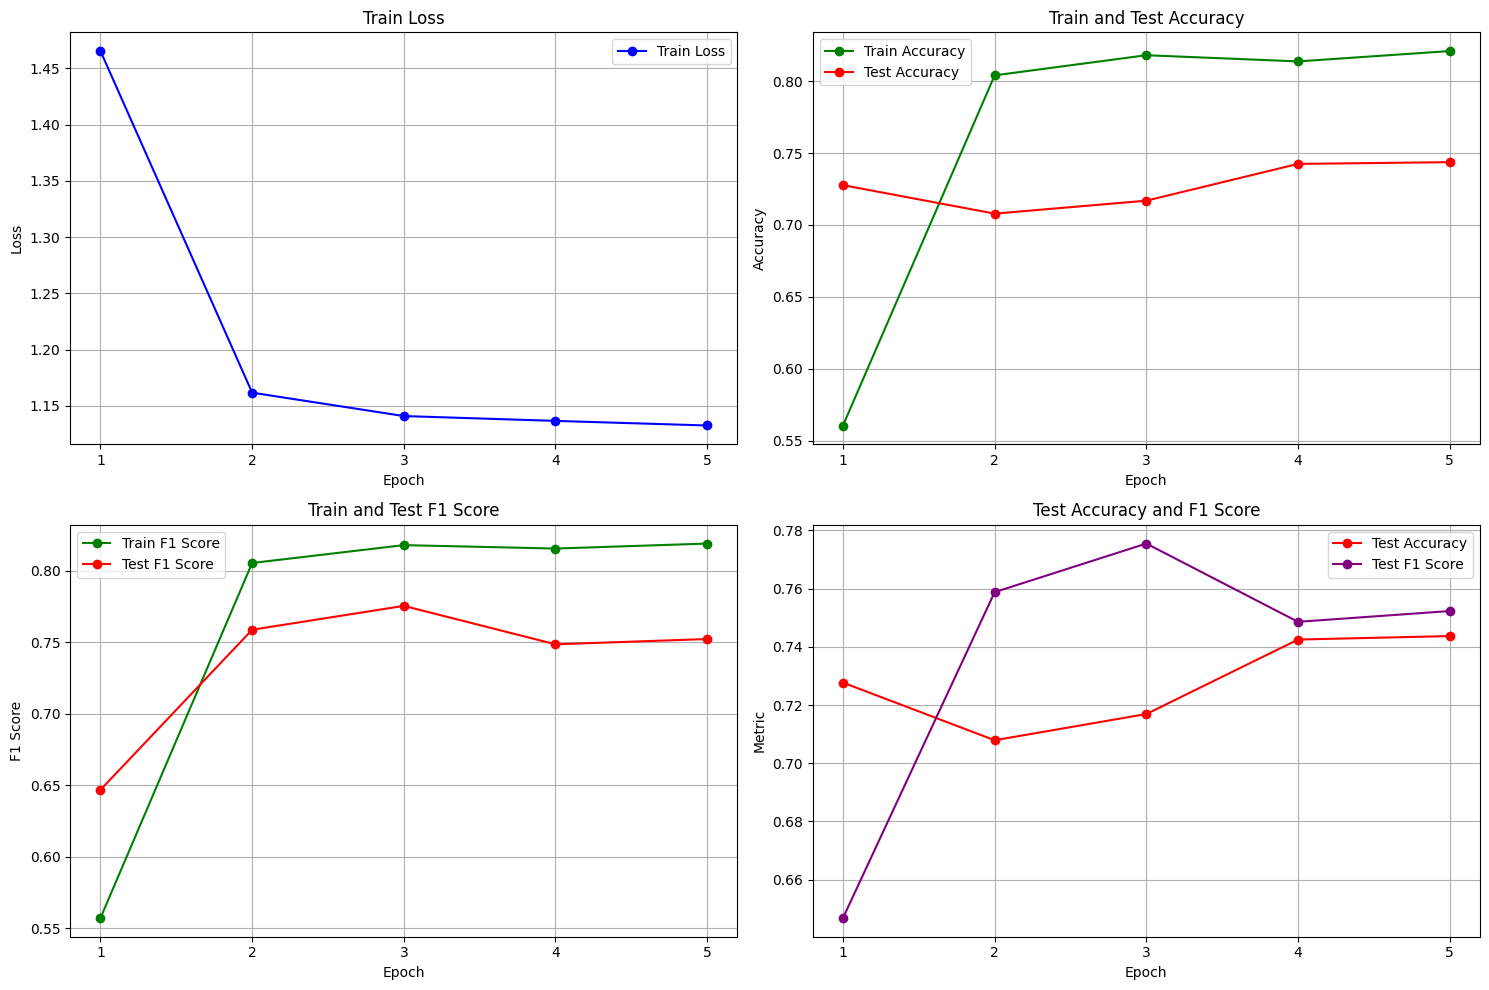

In [ ]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5]
train_losses = [1.4655, 1.1617, 1.1409, 1.1366, 1.1325]
train_accuracies = [0.5605, 0.8041, 0.8181, 0.8138, 0.8210]
test_accuracies = [0.7277, 0.7079, 0.7169, 0.7425, 0.7437]
train_f1_scores = [0.5571, 0.8055, 0.8180, 0.8156, 0.8191]
test_f1_scores = [0.6468, 0.7588, 0.7755, 0.7486, 0.7523]

# 시각화
plt.figure(figsize=(15, 10))

# Train Loss 시각화
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.xticks(epochs)
plt.grid(True)
plt.legend()

# Train Accuracy 시각화
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o', color='green')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.xticks(epochs)
plt.grid(True)
plt.legend()

# Train F1 Score 시각화
plt.subplot(2, 2, 3)
plt.plot(epochs, train_f1_scores, label='Train F1 Score', marker='o', color='green')
plt.plot(epochs, test_f1_scores, label='Test F1 Score', marker='o', color='red')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Train and Test F1 Score')
plt.xticks(epochs)
plt.grid(True)
plt.legend()

# Test Accuracy와 F1 Score 비교
plt.subplot(2, 2, 4)
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o', color='red')
plt.plot(epochs, test_f1_scores, label='Test F1 Score', marker='o', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Test Accuracy and F1 Score')
plt.xticks(epochs)
plt.grid(True)
plt.legend()

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

In [ ]:
# 저장 경로 설정 (Google Drive 내 원하는 폴더로 변경 가능)
save_path = '/content/drive/MyDrive/model_weights_softmax.pth'

# 모델 상태_dict 저장
torch.save(model.state_dict(), save_path)
print(f'Model saved to {save_path}')

Model saved to /content/drive/MyDrive/model_weights_softmax.pth


# 5. Kobert 모델 정의

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size=768,
                 num_classes=6,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
        self.sigmoid = nn.Sigmoid()
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=hidden_size, out_features=512),
            nn.Linear(in_features=512, out_features=num_classes),
        )

        # 정규화 레이어 추가 (Layer Normalization)
        self.layer_norm = nn.LayerNorm(768)

        # 드롭아웃
        self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        _, pooler = self.bert(input_ids=token_ids, token_type_ids=segment_ids.long(), attention_mask=attention_mask.float().to(token_ids.device))

        pooled_output = self.dropout(pooler)
        normalized_output = self.layer_norm(pooled_output)
        out = self.classifier(normalized_output)

        # LayerNorm 적용
        pooler = self.layer_norm(pooler)

        if self.dr_rate:
            pooler = self.dropout(pooler)

        logits = self.classifier(pooler)  # 분류를 위한 로짓 값 계산
        probabilities = self.sigmoid(logits)  # 각 클래스의 확률을 독립적으로 계산
        return probabilities  # 각 클래스에 대한 확률 반환

In [ ]:
#정의한 모델 불러오기
model = BERTClassifier(bertmodel,dr_rate=0.4).to(device)
#model = BERTClassifier(bertmodel,  dr_rate=0.5).to('cpu')

# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
train_dataloader

# 6. 모델 학습 및 평가

In [ ]:
from sklearn.metrics import f1_score

# 각 에포크의 F1 스코어를 저장할 리스트 초기화
train_f1_scores = []
test_f1_scores = []

# 모델 훈련 및 평가
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    total_loss = 0.0
    all_train_preds = []
    all_train_labels = []
    all_test_preds = []
    all_test_labels = []
    train_losses = []
    train_accuracies = []
    test_accuracies =[]
    avg_test_acc=0.0
    model.train()

    # 훈련 데이터 학습
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        total_loss += loss.item()
        train_acc += calc_accuracy(out, label)

        # 예측값과 실제 라벨 저장
        _, preds = torch.max(out, dim=1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(label.cpu().numpy())

    # 에포크별 평균 손실 및 정확도 계산
    avg_train_loss = total_loss / len(train_dataloader)
    avg_train_acc = train_acc / len(train_dataloader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # F1 스코어 계산
    train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')
    train_f1_scores.append(train_f1)

    print(f"epoch {e+1} train loss {avg_train_loss} train acc {avg_train_acc} train f1 {train_f1}")

    # 검증 데이터 평가
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)

        # 예측값과 실제 라벨 저장
        _, preds = torch.max(out, dim=1)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(label.cpu().numpy())

    # 에포크별 테스트 정확도 및 F1 스코어 계산
    avg_test_acc = test_acc / len(test_dataloader)
    test_accuracies.append(avg_test_acc)
    test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
    test_f1_scores.append(test_f1)

    print(f"epoch {e+1} test acc {avg_test_acc} test f1 {test_f1}")


<ipython-input-49-5be844c99c5b>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/480 [00:00<?, ?it/s]

epoch 1 train loss 1.4984812274575234 train acc 0.5439192708333334 train f1 0.5515093338570228


<ipython-input-49-5be844c99c5b>:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/350 [00:00<?, ?it/s]

epoch 1 test acc 0.4384496753246754 test f1 0.6341844737801191


<ipython-input-49-5be844c99c5b>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/480 [00:00<?, ?it/s]

epoch 2 train loss 1.1954821127156416 train acc 0.8135156250000001 train f1 0.8119463773918824


<ipython-input-49-5be844c99c5b>:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/350 [00:00<?, ?it/s]

epoch 2 test acc 0.6851136363636363 test f1 0.7235706019017675


<ipython-input-49-5be844c99c5b>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/480 [00:00<?, ?it/s]

epoch 3 train loss 1.172010854880015 train acc 0.8334739583333334 train f1 0.8329018227117165


<ipython-input-49-5be844c99c5b>:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/350 [00:00<?, ?it/s]

epoch 3 test acc 0.6438717532467532 test f1 0.7745264739566613


<ipython-input-49-5be844c99c5b>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/480 [00:00<?, ?it/s]

epoch 4 train loss 1.1678153718511264 train acc 0.8410546875 train f1 0.8387348420585453


<ipython-input-49-5be844c99c5b>:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/350 [00:00<?, ?it/s]

epoch 4 test acc 0.7144967532467532 test f1 0.8056897120803185


<ipython-input-49-5be844c99c5b>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/480 [00:00<?, ?it/s]

epoch 5 train loss 1.1651737535993258 train acc 0.8430729166666667 train f1 0.8434507681856087


<ipython-input-49-5be844c99c5b>:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/350 [00:00<?, ?it/s]

epoch 5 test acc 0.6828896103896104 test f1 0.7947998339994072


In [ ]:
#테스트
#토큰화
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
#tok = tokenizer.tokenize

sentence_emotions = []

def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tokenizer, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model (token_ids, valid_length, segment_ids)

        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            #emotions = [round(value.item() *100,2) for value in i]
            emotions = [value.item() for value in i]
            #print(emotions)
            sentence_emotions.append(emotions)
        print(sentence_emotions)

#질문 무한반복하기! 0 입력시 종료
sentence = input("하고싶은 말을 입력해주세요 : ")
predict(sentence)
#end = 1
#while end == 1 :
 #   sentence = input("하고싶은 말을 입력해주세요 : ")
 #   if sentence == '0' :
 #       break
 #   predict(sentence)
    #print("\n")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


하고싶은 말을 입력해주세요 : 열심히 준비한 시험을 망쳤어. 너무 우울하고 슬퍼.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[[0.00017774828302208334, 0.00015012639050837606, 0.00013937779294792563, 0.0001449245901312679, 0.9991403818130493, 0.00024746748385950923]]


In [ ]:
sentence_emotions

[[0.00017774828302208334,
  0.00015012639050837606,
  0.00013937779294792563,
  0.0001449245901312679,
  0.9991403818130493,
  0.00024746748385950923]]

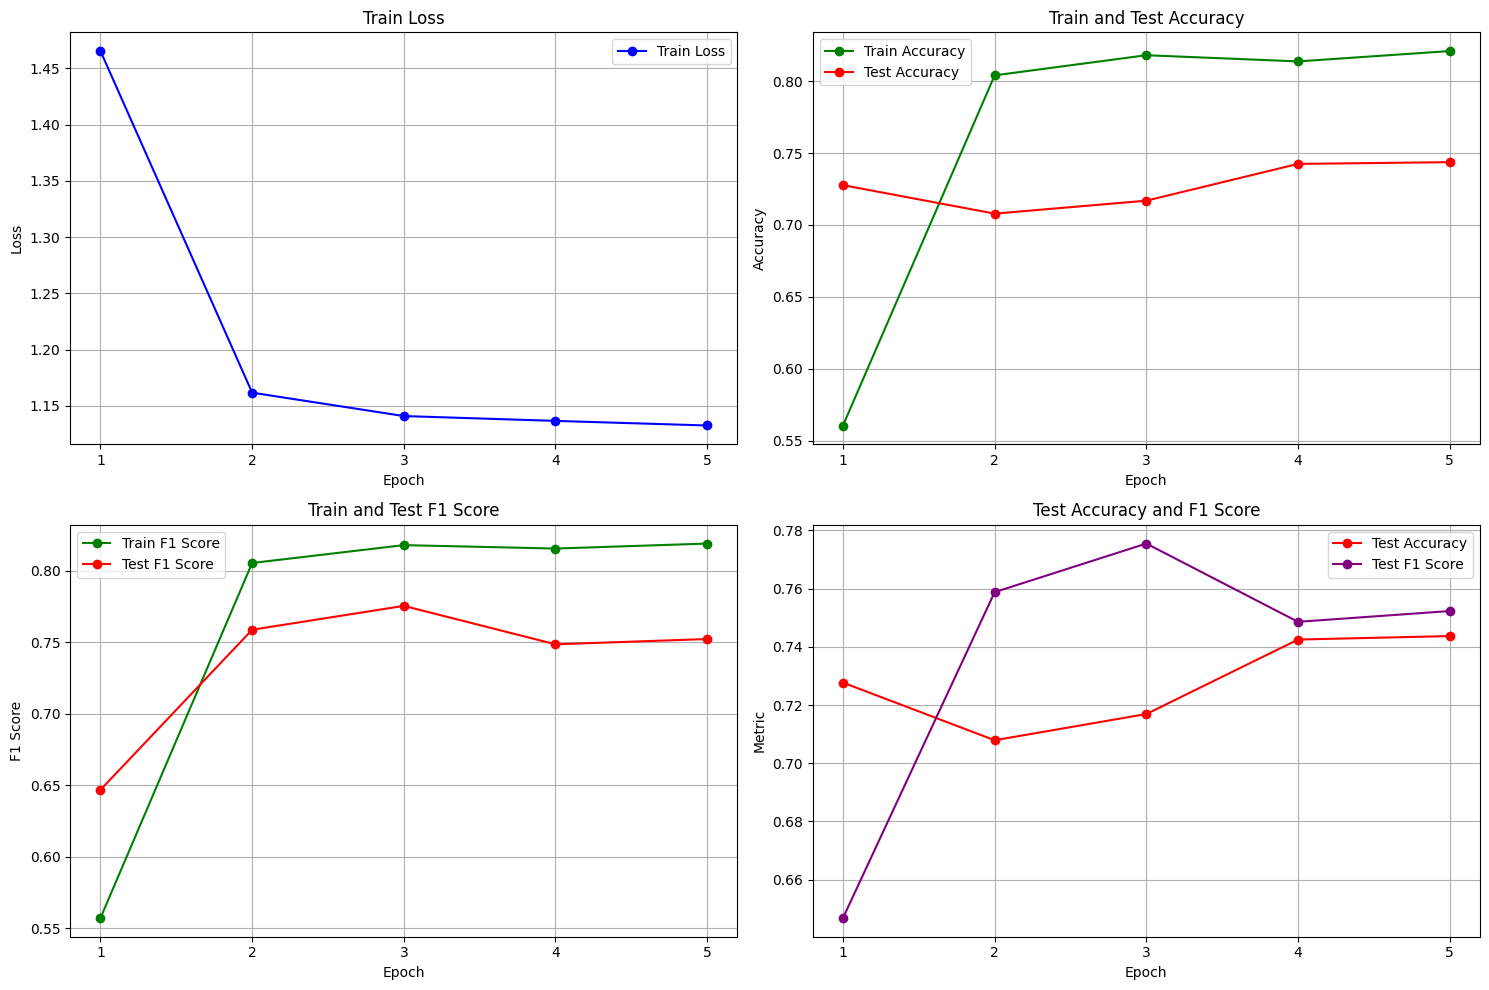

In [ ]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5]
train_losses = [1.4655, 1.1617, 1.1409, 1.1366, 1.1325]
train_accuracies = [0.5605, 0.8041, 0.8181, 0.8138, 0.8210]
test_accuracies = [0.7277, 0.7079, 0.7169, 0.7425, 0.7437]
train_f1_scores = [0.5571, 0.8055, 0.8180, 0.8156, 0.8191]
test_f1_scores = [0.6468, 0.7588, 0.7755, 0.7486, 0.7523]

# 시각화
plt.figure(figsize=(15, 10))

# Train Loss 시각화
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.xticks(epochs)
plt.grid(True)
plt.legend()

# Train Accuracy 시각화
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o', color='green')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.xticks(epochs)
plt.grid(True)
plt.legend()

# Train F1 Score 시각화
plt.subplot(2, 2, 3)
plt.plot(epochs, train_f1_scores, label='Train F1 Score', marker='o', color='green')
plt.plot(epochs, test_f1_scores, label='Test F1 Score', marker='o', color='red')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Train and Test F1 Score')
plt.xticks(epochs)
plt.grid(True)
plt.legend()

# Test Accuracy와 F1 Score 비교
plt.subplot(2, 2, 4)
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o', color='red')
plt.plot(epochs, test_f1_scores, label='Test F1 Score', marker='o', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Test Accuracy and F1 Score')
plt.xticks(epochs)
plt.grid(True)
plt.legend()

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

*   model_weight: 감정벡터 값 비슷하게
*   model_weight2: 특정 라벨링 높게



In [ ]:
# 저장 경로 설정 (Google Drive 내 원하는 폴더로 변경 가능)
save_path = '/content/drive/MyDrive/model_weights2.pth'

# 모델 상태_dict 저장
torch.save(model.state_dict(), save_path)
print(f'Model saved to {save_path}')

NameError: name 'model' is not defined

#7. 모델 불러오기

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 모델 불러오기
model_path = '/content/drive/MyDrive/캡스톤6조/kobert/model_weights_softmax.pth'
model = BERTClassifier(bertmodel, dr_rate=0.4).to(device)
model.load_state_dict(torch.load(model_path))
model.eval() # 평가모드로 변경

<ipython-input-56-24c114d0d82e>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

#8. 멜론데이터 감정 벡터 계산

In [ ]:
melon = pd.read_csv('/content/drive/MyDrive/캡스톤6조/멜론/melonData2.csv')
melon

,Unnamed: 0,title,new_lyric
0,0,뱅뱅뱅 (BANG BANG BANG),난 깨어나 까만 밤과 함께 다 들어와 담엔 누구 차례 한 치 앞도 볼 수 없는 막장...
1,1,뱅뱅뱅 (BANG BANG BANG),찌질한 분위기를 전환해 광기를 감추지 못하게 해 남자들의 품위 여자들의 가식 이유 ...
2,2,뱅뱅뱅 (BANG BANG BANG),난 보란 듯이 너무나도 뻔히 니 몸속에 파고드는 알러지 이상한 정신의 술렁이는 천지...
3,3,뱅뱅뱅 (BANG BANG BANG),난 불을 질러 심장을 태워 널 미치게 하고 싶어 모두 다 같이
4,4,뱅뱅뱅 (BANG BANG BANG),총 맞은 것처럼 빵야 빵야 빵야 빵야 빵야 빵야 다 꼼짝 마라 다 꼼짝 마
...,...,...,...
14644,14644,가을밤에 든 생각,새까만 밤하늘을 수놓은 별빛마저 불어오는 바람 따라가고 보고픈 그대 생각 짙어져 가...
14645,14645,가을밤에 든 생각,부르다 보면 어제가 올까 그립던 날이 참 많았는데 저 멀리 반짝이다 아련히 멀어져 가는
14646,14646,가을밤에 든 생각,너는 작은 별 같아 멀어져 가는 새까만 밤하늘을 수놓은 별빛마저 불어오는 바람 따라 가고
14647,14647,가을밤에 든 생각,보고픈 그대 생각 짙어져 가는 시월의 아름다운 이 밤에 수많은 바람 불어온대도 날려...


In [ ]:
# prompt: melon 데이터 행 300개만 새로운 데이터프레임에 저장

melon_300 = melon

In [ ]:
melon_300

,Unnamed: 0,title,new_lyric
0,0,뱅뱅뱅 (BANG BANG BANG),난 깨어나 까만 밤과 함께 다 들어와 담엔 누구 차례 한 치 앞도 볼 수 없는 막장...
1,1,뱅뱅뱅 (BANG BANG BANG),찌질한 분위기를 전환해 광기를 감추지 못하게 해 남자들의 품위 여자들의 가식 이유 ...
2,2,뱅뱅뱅 (BANG BANG BANG),난 보란 듯이 너무나도 뻔히 니 몸속에 파고드는 알러지 이상한 정신의 술렁이는 천지...
3,3,뱅뱅뱅 (BANG BANG BANG),난 불을 질러 심장을 태워 널 미치게 하고 싶어 모두 다 같이
4,4,뱅뱅뱅 (BANG BANG BANG),총 맞은 것처럼 빵야 빵야 빵야 빵야 빵야 빵야 다 꼼짝 마라 다 꼼짝 마
...,...,...,...
14644,14644,가을밤에 든 생각,새까만 밤하늘을 수놓은 별빛마저 불어오는 바람 따라가고 보고픈 그대 생각 짙어져 가...
14645,14645,가을밤에 든 생각,부르다 보면 어제가 올까 그립던 날이 참 많았는데 저 멀리 반짝이다 아련히 멀어져 가는
14646,14646,가을밤에 든 생각,너는 작은 별 같아 멀어져 가는 새까만 밤하늘을 수놓은 별빛마저 불어오는 바람 따라 가고
14647,14647,가을밤에 든 생각,보고픈 그대 생각 짙어져 가는 시월의 아름다운 이 밤에 수많은 바람 불어온대도 날려...


In [ ]:
#테스트
#토큰화
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')


def sum_predict(a, logits):
    for j in range(6):
      emotions[a][j] = emotions[a][j] + (logits[j].item() *100)

def predict(predict_sentence,a ,k):

    data = [predict_sentence, 0]
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tokenizer, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length = valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        for i in out:
            logits = i.detach().cpu().numpy()

            emotions = [value.item() *100 for value in i]
            #print(emotions)
        #print(melon_300['title'][k], a)
        sum_predict(a, logits)

# 감정 배열 초기화
emotions = [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0] for i in range(1501)]
# 각 title의 개수를 저장할 리스트
title_count = [0 for i in range(1501)]
# title과 감정 데이터를 저장할 리스트
emotion_data = []
# 예시 데이터 처리
a = 0  # 현재 title에 해당하는 index
k = 0  # 전체 가사 index

for lyric in melon_300['new_lyric']:
    print(k)
    predict(lyric, a, k)

    # 첫 번째 가사일 때는 title 비교를 건너뜀
    if k > 0:
      if (k+1) == len(melon_300['title']):
        if title_count[a] > 0:
            emotions[a] = [e / title_count[a] for e in emotions[a]]
        #print(title_count[a])
        break
      if melon_300['title'][k] == melon_300['title'][k+1]:
        title_count[a] += 1
      else:
        # 만약 title이 바뀌면 이전 title의 감정 값을 count로 나누고 index 업데이트
        if title_count[a] > 0:
            emotions[a] = [e / title_count[a] for e in emotions[a]]
        #print(title_count[a])

        # 새로운 title과 감정 데이터 저장
        emotion_data.append([melon_300['title'][k], emotions[a]])

        # 새로운 title을 위한 초기화
        a += 1
        title_count[a] = 1  # 새로운 title 카운트 시작
    else:
      # 첫 번째 title에 대해 초기 카운트 설정
      title_count[a] = 2

    k += 1

# 마지막 title 처리
if title_count[a] > 0:
    emotions[a] = [e / title_count[a] for e in emotions[a]]
    emotion_data.append([melon_300['title'][k], emotions[a]])


# DataFrame 생성
emotion_df = pd.DataFrame(emotion_data, columns=['Title', 'Emotions'])

# DataFrame 출력
print(emotion_df)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
9676
9677
9678
9679
9680
9681
9682
9683
9684
9685
9686
9687
9688
9689
9690
9691
9692
9693
9694
9695
9696
9697
9698
9699
9700
9701
9702
9703
9704
9705
9706
9707
9708
9709
9710
9711
9712
9713
9714
9715
9716
9717
9718
9719
9720
9721
9722
9723
9724
9725
9726
9727
9728
9729
9730
9731
9732
9733
9734
9735
9736
9737
9738
9739
9740
9741
9742
9743
9744
9745
9746
9747
9748
9749
9750
9751
9752
9753
9754
9755
9756
9757
9758
9759
9760
9761
9762
9763
9764
9765
9766
9767
9768
9769
9770
9771
9772
9773
9774
9775
9776
9777
9778
9779
9780
9781
9782
9783
9784
9785
9786
9787
9788
9789
9790
9791
9792
9793
9794
9795
9796
9797
9798
9799
9800
9801
9802
9803
9804
9805
9806
9807
9808
9809
9810
9811
9812
9813
9814
9815
9816
9817
9818
9819
9820
9821
9822
9823
9824
9825
9826
9827
9828
9829
9830
9831
9832
9833
9834
9835
9836
9837
9838
9839
9840
9841
9842
9843
9844
9845
9846
9847
9848
9849
9850
9851
9852
9853
9854
9855
9856
9857
9858
9859
9860
9861
9862
9863
9864
9865
9866
9867
9868

In [ ]:
#테스트 노래 가사 전체 - melonData3 ver.
#토큰화
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')


def sum_predict(a, logits):
    for j in range(6):
      emotions[a][j] = emotions[a][j] + (logits[j].item() *100)

def predict(predict_sentence,a ,k):

    data = [predict_sentence, 0]
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tokenizer, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length = valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        for i in out:
            logits = i.detach().cpu().numpy()

            emotions = [value.item() *100 for value in i]
        emotion_data.append([melon['title'][k], emotions])

# 감정 배열 초기화
emotions = [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0] for i in range(1501)]
# title과 감정 데이터를 저장할 리스트
emotion_data = []
# 예시 데이터 처리
a = 0  # 현재 title에 해당하는 index
k = 0  # 전체 가사 index

for lyric in melon['new_lyric']:
    print(lyric)
    predict(lyric, a, k)
    k += 1

# DataFrame 생성
emotion_df = pd.DataFrame(emotion_data, columns=['Title', 'Emotions'])

# DataFrame 출력
print(emotion_df)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


난 깨어나 까만 밤과 함께 다 들어와 담엔 누구 차례 한 치 앞도 볼 수 없는 막장 게릴라 경배하라 목청이 터지게


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


찌질한 분위기를 전환해 광기를 감추지 못하게 해 남자들의 품위 여자들의 가식 이유 모를 자신감이 볼만해
난 보란 듯이 너무나도 뻔히 니 몸속에 파고드는 알러지 이상한 정신의 술렁이는 천지 오늘 여기 무법지
난 불을 질러 심장을 태워 널 미치게 하고 싶어 모두 다 같이
총 맞은 것처럼 빵야 빵야 빵야 빵야 빵야 빵야 다 꼼짝 마라 다 꼼짝 마
다 꼼짝 마라 다 꼼짝 마 오늘 밤 끝장 보자 다 끝장 봐 오늘 밤 끝장 보자 빵야 빵야 빵야
널 데려가 지금 이 순간에 새빨간 저 하늘이 춤출 때 돌고 돌아 너와 나 이곳은  찬양하라 더 울려 퍼지게
불침번 밤새 달려 축지법 이 노래는 꼭지점 신이나 불러라 신점
큰 비명소리는 마성의 멜로디 검은 독기의 연결 고리 사방 팔방 오방 가서 푸는 고삐  난 불을 질러
네 심장을 태워 널 미치게 하고 싶어 모두 다 같이 총 맞은 것처럼
빵야 빵야 빵야 빵야 빵야 빵야 다 꼼짝 마라 다 꼼짝 마 다 꼼짝 마라 다 꼼짝 마
오늘 밤 끝장 보자 다 끝장 봐 오늘 밤 끝장 보자 빵야 빵야 빵야 남자들은 위로
여자들은  당겨라  남자들은 위로 여자들은 
당겨라
꼭 그러지 않아도 충분히 널 이해할 수 있어 다른 사람 곁에 서 있는 니 모습이 조금 어색하지만
다 버리지 않아도 어떻게든 이겨낼 수 있어 다른 사랑 찾아가버린 니 얼굴이 그렇게 밉진 않아
이제 우리 같은 시간 속을 남처럼 그렇게 걸으면 돼 달아나도 가지 못할 기억 안고 아무말도 하지마요
더는 안된다는거 잘 알아요 많은 날들이 아무 의미없진 않겠죠 멀어지는 바람처럼 우리 함께한 기억들을 꿈처럼
그렇게 안으면 돼 눈 감아도 잊지 못할 추억의 널 묻고 아무말도 하지마요 더는 안된다는거 잘 알아요
사랑했던 날 모두 사라지진 않겠죠 우릴 스치는 안개처럼 아무것도 묻지 않을게요 이대로 묻어둘래요 나는요
거짓말처럼 또 하루가 살아지겠죠 떨어지는 같은 시간 속의 너
안녕 쉽지 않죠 바쁘죠 왜 이렇게 까지 해야 하나 싶죠
바라는 게 더럽게 많죠 그렇죠 쉬고 싶죠
시끄럽죠 다 성가시죠 집에 가고 싶

In [ ]:
pd.set_option('display.max_colwidth', None) # Change -1 to None

In [ ]:
emotion_df

,Title,Emotions
0,뱅뱅뱅 (BANG BANG BANG),"[8.370585111229698, 0.014356899354035184, 15.168436503985763, 72.85238693750996, 3.5808714772948798, 0.01336528102910961]"
1,같은 시간 속의 너,"[0.5950805854029438, 0.01936531309963487, 24.773393428742047, 41.81469005551272, 32.74652553233994, 0.05094336339815137]"
2,꺼내 먹어요,"[21.91882485818092, 0.015464704867756356, 11.629119250897524, 46.61807532239537, 19.806163295389624, 0.01235375989886557]"
3,이럴거면 그러지말지 (Feat. Young K),"[7.826145036999931, 0.008968889272052496, 0.17706640537653584, 49.87123368908734, 42.09216423000076, 0.0244225110561404]"
4,위잉위잉,"[0.059696367655609116, 0.003976963162131142, 7.840061795529134, 47.50180098446435, 44.581234358617316, 0.013231064597979033]"
...,...,...
1219,가까운 듯 먼 그대여,"[66.99402280216115, 0.08390939163089367, 23.991665655881256, 1.3971637384505204, 7.501346881488441, 0.03189167534098184]"
1220,면도,"[0.7549894550510754, 0.015654553890971538, 6.860249367141828, 48.55698763992852, 43.76736125514771, 0.04475684374763379]"
1221,Do or Die,"[27.88072930499246, 0.01766378175359153, 3.162597379663826, 30.171499620856984, 38.74624915354486, 0.0212571448563332]"
1222,숲,"[14.261742647847443, 0.004786645110600928, 0.11089545899137322, 45.10677936320592, 40.50197500203337, 0.013819727766011576]"


In [ ]:
emotion_df.to_csv('melon_emotions.csv')

In [ ]:
# prompt: emotion_df['Emotions'] list로 변환

emotions = emotion_df['Emotions'].tolist()

In [ ]:
emotions

[[0.49945992367741254,
  0.013562229162614261,
  0.1833963966263192,
  0.573404172701495,
  0.662164988794497,
  0.017369603339050497],
 [0.0697478236896651,
  0.012522659530597073,
  0.31338428566232324,
  0.6868476537721497,
  0.7184962976191726,
  0.020293188148311207],
 [0.36577414752294624,
  0.01817507731417815,
  0.16015673677126568,
  0.570620738590757,
  0.6129398056202464,
  0.02252384161369668],
 [0.4304630189601864,
  0.00812106438180698,
  0.1520248255027192,
  0.5975961368530989,
  0.6952249487595898,
  0.011688970910784389],
 [0.11172127705067396,
  0.015593172485629718,
  0.1959101031223933,
  0.8172306329011917,
  0.8461285752554734,
  0.018594425699363152],
 [0.08553455444052815,
  0.02045833063311875,
  0.08787322521675378,
  0.9255932327359915,
  0.9536312520503998,
  0.02321768511319533],
 [0.44548761227633804,
  0.010426368156913668,
  0.4124599973050257,
  0.3396840270919105,
  0.4199643013998866,
  0.011809925083070993],
 [0.09187505197607809,
  0.00887929635225

#9. 코사인 유사도

In [ ]:
print(type(sentence_emotions))
print(type(emotions))

<class 'list'>
<class 'list'>


In [ ]:
# 코사인 유사도 함수
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    if norm_vec1 == 0 or norm_vec2 == 0:
        return np.nan  # 제로 벡터인 경우 NaN 반환
    return dot_product / (norm_vec1 * norm_vec2)

# 각 노래에 대한 코사인 유사도 계산
similarities = [cosine_similarity(sentence_emotions[0], song_vec) for song_vec in emotions]

# 유사도가 NaN이 아닌 인덱스만 필터링
valid_indices = [i for i, sim in enumerate(similarities) if not np.isnan(sim)]
filtered_similarities = [similarities[i] for i in valid_indices]

recommendations = np.argsort(filtered_similarities)[::-1]  # 높은 유사도 순으로 인덱스 정렬
print(recommendations)
# 결과를 데이터프레임으로 만들기
results_df = pd.DataFrame({
    'Song Index': recommendations + 1,  # 노래 인덱스 (1부터 시작)
    'title' : emotion_df['Title'].iloc[recommendations].values,
    'Cosine Similarity': [similarities[idx] for idx in recommendations]
})

# 데이터프레임 출력
print(results_df)

[1001  416  283 ... 1200  917 1140]
      Song Index          title  Cosine Similarity
0           1002          비와 당신           0.999501
1            417     아름답고도 아프구나           0.993512
2            284            열애중           0.993336
3            791          잘 있나요           0.990644
4            249       나의 사춘기에게           0.988723
...          ...            ...                ...
1219        1144     Like Crazy           0.001900
1220        1219  Watch Me Woo!           0.001383
1221        1201         오래된 노래           0.000922
1222         918     너를 사랑하고 있어           0.000477
1223        1141      New Jeans           0.000164

[1224 rows x 3 columns]


In [ ]:
print(sentence)

열심히 준비한 시험을 망쳤어. 너무 우울하고 슬퍼.


In [ ]:
results_df

,Song Index,title,Cosine Similarity
0,1002,비와 당신,0.999501
1,417,아름답고도 아프구나,0.993512
2,284,열애중,0.993336
3,791,잘 있나요,0.990644
4,249,나의 사춘기에게,0.988723
...,...,...,...
1219,1144,Like Crazy,0.001900
1220,1219,Watch Me Woo!,0.001383
1221,1201,오래된 노래,0.000922
1222,918,너를 사랑하고 있어,0.000477


In [ ]:
# prompt: Song Index 제거한 데이터 프레임

abc = results_df.drop(columns=['Song Index'])

In [ ]:
abc.head(5)

,title,Cosine Similarity
0,비와 당신,0.999501
1,아름답고도 아프구나,0.993512
2,열애중,0.993336
3,잘 있나요,0.990644
4,나의 사춘기에게,0.988723


In [ ]:
abc.tail(5)

,title,Cosine Similarity
1219,Like Crazy,0.001900
1220,Watch Me Woo!,0.001383
1221,오래된 노래,0.000922
1222,너를 사랑하고 있어,0.000477
1223,New Jeans,0.000164


#10. 코사인 유사도(log)

In [ ]:
sentence

'열심히 준비한 시험을 망쳤어. 너무 우울하고 슬퍼.'

In [ ]:
sentence_emotions

[[0.00017774828302208334,
  0.00015012639050837606,
  0.00013937779294792563,
  0.0001449245901312679,
  0.9991403818130493,
  0.00024746748385950923]]

In [ ]:
import numpy as np

In [ ]:
sentence_emotions2 = [0]
emotions2 = [0]

In [ ]:
sentence_emotions2[0] = np.log1p(sentence_emotions[0])
sentence_emotions2[0]

array([1.77732488e-04, 1.50115123e-04, 1.39368081e-04, 1.44914090e-04,
       6.92717279e-01, 2.47436869e-04])

In [ ]:
emotions2 = np.log1p(emotions)
emotions2

array([[2.23757554, 0.01425481, 2.78306098, 4.30206833, 1.52188926,
        0.01327675],
       [0.46692426, 0.01918019, 3.2493427 , 3.75688127, 3.51887746,
        0.0496882 ],
       [3.13195862, 0.01534635, 2.5360052 , 3.86321242, 3.03524926,
        0.01227807],
       ...,
       [3.36317457, 0.01750959, 1.42613925, 3.4395042 , 3.68251548,
        0.02103436],
       [2.72534922, 0.00477523, 0.10516641, 3.83096   , 3.72574102,
        0.01372511],
       [1.90664793, 0.03390763, 1.0755728 , 1.53812755, 1.44726599,
        1.11928926]])

In [ ]:
# 코사인 유사도 함수
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    if norm_vec1 == 0 or norm_vec2 == 0:
        return np.nan  # 제로 벡터인 경우 NaN 반환
    return dot_product / (norm_vec1 * norm_vec2)

# 각 노래에 대한 코사인 유사도 계산
similarities = [cosine_similarity(sentence_emotions2[0], song_vec) for song_vec in emotions2]

# 유사도가 NaN이 아닌 인덱스만 필터링
valid_indices = [i for i, sim in enumerate(similarities) if not np.isnan(sim)]
filtered_similarities = [similarities[i] for i in valid_indices]

recommendations = np.argsort(filtered_similarities)[::-1]  # 높은 유사도 순으로 인덱스 정렬
print(recommendations)
# 결과를 데이터프레임으로 만들기
results_df = pd.DataFrame({
    'Song Index': recommendations + 1,  # 노래 인덱스 (1부터 시작)
    'title' : emotion_df['Title'].iloc[recommendations].values,
    'Cosine Similarity': [similarities[idx] for idx in recommendations]
})

# 데이터프레임 출력
print(results_df)

[1001  790  283 ... 1200  917 1140]
      Song Index          title  Cosine Similarity
0           1002          비와 당신           0.942418
1            791          잘 있나요           0.839623
2            284            열애중           0.835888
3            249       나의 사춘기에게           0.835756
4            417     아름답고도 아프구나           0.829708
...          ...            ...                ...
1219        1144     Like Crazy           0.023721
1220        1219  Watch Me Woo!           0.015717
1221        1201         오래된 노래           0.007528
1222         918     너를 사랑하고 있어           0.003764
1223        1141      New Jeans           0.000727

[1224 rows x 3 columns]


In [ ]:
results_df.head(7)

,Song Index,title,Cosine Similarity
0,1002,비와 당신,0.942418
1,791,잘 있나요,0.839623
2,284,열애중,0.835888
3,249,나의 사춘기에게,0.835756
4,417,아름답고도 아프구나,0.829708
5,805,만약에 말야 (전우성 Solo),0.828823
6,1030,살다가,0.806218


In [ ]:
# prompt: Song Index 제거한 데이터 프레임

abc2 = results_df.drop(columns=['Song Index'])

In [ ]:
abc2.head()

,title,Cosine Similarity
0,비와 당신,0.942418
1,잘 있나요,0.839623
2,열애중,0.835888
3,나의 사춘기에게,0.835756
4,아름답고도 아프구나,0.829708


In [ ]:
# prompt: abc2 'Cosine Similarity' 제일 낮은 값부터

abc2 = abc2.sort_values(by='Cosine Similarity', ascending=True)
abc2.head()

,title,Cosine Similarity
1223,New Jeans,0.000727
1222,너를 사랑하고 있어,0.003764
1221,오래된 노래,0.007528
1220,Watch Me Woo!,0.015717
1219,Like Crazy,0.023721


#11. 콘텐츠 기반 필터링

In [ ]:
def compute_overall_similarity(emotion_similarity, genre_similarity, artist_similarity, year_similarity, tempo_similarity, popularity_similarity, weights):
    # 가중치를 부여하여 종합 유사도 계산
    overall_similarity = (
        weights['emotion'] * emotion_similarity +
        weights['genre'] * genre_similarity +
        weights['artist'] * artist_similarity +
        weights['year'] * year_similarity +
        weights['tempo'] * tempo_similarity +
        weights['popularity'] * popularity_similarity
    )
    return overall_similarity

# 예제 가중치
weights = {
    'emotion': 0.4,
    'genre': 0.3,
    'artist': 0.1,
    'year': 0.05,
    'tempo': 0.1,
    'popularity': 0.05
}

# 예시 유사도 점수들
overall_similarity = compute_overall_similarity(0.85, 0.9, 1.0, 0.75, 0.8, 0.7, weights)
print(f"Overall Similarity: {overall_similarity}")
